<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_WDM_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of coherent WDM transmission

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, firFilter, decimate, symbolSync, pnorm, signal_power
from optic.models.devices import pdmCoherentReceiver, basicLaserModel

try:
    from optic.models.modelsGPU import manakovSSF
except:
    from optic.models.channels import manakovSSF

from optic.models.tx import simpleWDMTx
from optic.utils import parameters, dBm2W
from optic.dsp.equalization import edc, mimoAdaptEqualizer
from optic.dsp.carrierRecovery import cpr
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM
from optic.plot import pconst, plotPSD

import scipy.constants as const

import logging as logg
logg.basicConfig(level=logg.INFO, format='%(message)s', force=True)

c:\Users\edson.DESKTOP-54IJM4F\anaconda3\envs\opticommpy-env\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

In [5]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler

## Summary

OptiCommPy is a Python package for simulating optical communication systems, including Wavelength Division Multiplexing (WDM) systems. This notebook shows an example of how to use OptiCommPy to run a simulation of a coherent WDM system with several modulated co-propagating optical carriers.


## Transmitter

The initial step involves defining a comprehensive set of parameters for the WDM transmitters. The table below outlines a specific WDM system configuration where $11\times32$GBd PDM-16QAM carriers are generated, following a frequency grid of 37.5 GHz that is centered precisely at the optical frequency of 193.1 THz. Each carrier is modulated with a Nyquist spectrum, by means of a root-raised-cosine (RRC) pulse-shaping filter with a rolloff factor of 0.01. The continuous-wave (CW) lasers utilized in this setup are characterized by linewidths of 100 kHz, with each modulated carrier boasting an output power of -2 dBm. 

| Parameter      | Description                                    | Value        |
|----------------|------------------------------------------------|--------------|
| M              | Order of the modulation format                 | 16           |
| Rs             | Symbol rate [baud]                             | 32e9         |
| SpS            | Samples per symbol                             | 16           |
| pulse          | Pulse shaping filter                           | 'rrc'        |
| nPulseTaps     | Number of pulse shaping filter coefficients    | 4096         |
| pulseRollOff   | RRC rolloff                                    | 0.01         |
| powerPerChannel| Power per WDM channel [dBm]                    | -2           |
| nChannels      | Number of WDM channels                         | 11           |
| Fc             | Central frequency of the WDM spectrum [Hz]     | 193.1e12     |
| laserLinewidth | Laser linewidth [Hz]                           | 100e3        |
| wdmGridSpacing | WDM grid spacing [Hz]                          | 37.5e9       |
| nPolModes      | Number of polarization modes                   | 2            |
| nBits          | Total number of bits per polarization          | 400000       |

The number of samples per symbol (SpS) adopted in the simulation is set to 16, meaning that the signals are represented at a corresponding sampling rate (Fs) of Fs = 16$\times$Rs = 512 GSa/s, where Rs is the symbol rate (i.e. 32GBd). The total bandwidth simulated in this setup is 11$\times$37.5 GHz = 412.5 GHz, which is below Fs, thus avoiding aliasing in the extremes of the spectrum. The total simulated interval corresponds to 100000 signaling periods, corresponding to 400000 bits transmitted per polarization per WDM carrier.


**Polarization multiplexed WDM signal generation**

In [19]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 16  # order of the modulation format
paramTx.Rs  = 32e9 # symbol rate [baud]
paramTx.SpS = 16  # samples per symbol
paramTx.pulseType = 'rrc' # pulse shaping filter
paramTx.nFilterTaps = 4096 # number of pulse shaping filter coefficients
paramTx.pulseRollOff = 0.01 # RRC rolloff
paramTx.powerPerChannel = -2 # power per WDM channel [dBm]
paramTx.nChannels = 11 # number of WDM channels
paramTx.Fc = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.laserLinewidth = 100e3 # laser linewidth in Hz
paramTx.wdmGridSpacing = 37.5e9 # WDM grid spacing
paramTx.nPolModes = 2  # number of signal modes [2 for polarization multiplexed signals]
paramTx.nBits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

  0%|          | 0/11 [00:00<?, ?it/s]

channel 0	 fc : 192.9125 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 0	 power: -2.00 dBm

channel 1	 fc : 192.9500 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 1	 power: -2.00 dBm

channel 2	 fc : 192.9875 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 2	 power: -2.00 dBm

channel 3	 fc : 193.0250 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 3	 power: -2.00 dBm

channel 4	 fc : 193.0625 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 4	 power: -2.00 dBm

channel 5	 fc : 193.1000 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 5	 power: -2.00 dBm

channel 6	 fc : 193.1375 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 6	 power: -2.00 dBm

channel 7	 fc : 193.1750 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 7	 power: -2.00 dBm

channel 8	 fc : 193.2125 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
cha

## Nonlinear fiber model

### Vector Manakov Equation

When considering two polarizations propagating over an optical fiber, the Manakov model can be used to describe the coupled propagation of two orthogonal polarization components, taking into account their mutual interactions and the characteristics of the fiber such as attenuation, nonlinearity and dispersion.

The vectorial Manakov equation is a system of coupled nonlinear Schrödinger equations (NLSEs) for the two polarizations, $x$ and $y$, written in the following form:

$$ \frac{\partial E_x(z,t)}{\partial z} +\frac{\alpha}{2}E_x(z,t) + j\frac{\beta_2}{2}\frac{\partial^2 E_x(z,t)}{\partial t^2} - j\frac{8\gamma}{9}\left(|E_x(z,t)|^2 + |E_y(z,t)|^2\right)E_x(z,t) = 0 $$

$$ \frac{\partial E_y(z,t)}{\partial z} +\frac{\alpha}{2}E_y(z,t) + j\frac{\beta_2}{2}\frac{\partial^2 E_y(z,t)}{\partial t^2} - j\frac{8\gamma}{9}\left(|E_x(z,t)|^2 + |E_y(z,t)|^2\right)E_y(z,t) = 0 $$

where:

* $E_x(z,t)$ and $E_y(z,t)$ are the complex-valued electric field envelopes for the $x$ and $y$ polarizations, respectively.
* $z$ is the propagation distance along the fiber.
* $t$ is time.
* $\beta_2$ is the group velocity dispersion (GVD) parameter of the fiber.
* $\gamma$ is the nonlinear coefficient of the fiber.

These equations model the linear effects of fiber attenuation and chromatic dispersion, and the nonlinear distortions originated from self-phase modulation (SPM), cross-phase modulation (XPM) and four-wave-mixing (FWM). The Manakov model is formulated under the assumption that the impact of polarization mode dispersion (PMD) effects is significantly smaller compared to the nonlinear effects and the characteristic length scales involved. This assumption implies that the beat length associated with PMD is much shorter than the nonlinear effective length of the fiber. In this context, the resulting nonlinear term in the Manakov equation represents an averaged effect of the fiber's nonlinearity, accounting for the rapid variations in the polarization states as the optical signal propagates through the fiber. This averaging captures the overall influence of the fiber's nonlinearity on the signal, considering the dynamic changes in polarization states over short distances.

### Nonlinear fiber propagation with a symmetric split-step Fourier method

The Split-Step Fourier Method (SSFM) is a powerful numerical technique extensively utilized in optical fiber communications to solve the NLSE, which governs the propagation of optical signals in fibers. It's designed to handle the intricate interplay of linear and nonlinear effects accumulated over long propagation distances. The fundamental concept of SSFM involves breaking down the complicated task of describing the signal propagation over long distances of fiber into a iterative sequence of simple calculation steps, involving time and frequency domain representations of the propagating signal. By assuming the independence of linear and nonlinear effects at each small propagation step, they can be applied to the signals independently in an iterative manner, ensuring accurate modeling of optical phenomena.

The coupled Manakov equations described above can be numerically integrated via split-step Fourier methods. A pseudocode for the SSFM algorithm is shown below.

*Pseudocode of the SSFM that solves the Manakov propagation model*

1. *Initialize:*
   - Parameters: $L$, $h_z$, $\Delta t$, $E_x(z=0,t)$, $E_x(z=0,t)$ (input fields)
   
2. *Loop for propagation over $L$:*
    
    for $z = 0$ to $L$ with step $h_z$:

    *Half-linear step*:
    - $E_x(z,t)\gets \mathrm{IFFT}\left\lbrace\exp\left[\left(-\frac{\alpha}{2}-j\frac{\beta_2 \omega^2}{2}\right) h_z/2\right] \mathrm{FFT}[E_x(z,t)]\right\rbrace$
    - $E_y(z,t)\gets \mathrm{IFFT}\left\lbrace\exp\left[\left(-\frac{\alpha}{2}-j\frac{\beta_2 \omega^2}{2}\right) h_z/2\right]  \mathrm{FFT}[E_y(z,t)]\right\rbrace$
    
    *Nonlinear phase rotation step:*
    - $E_x(z,t) \gets E_x(z,t)\exp\left[-j8\gamma/9 \left(|E_x(z,t)|^2 + |E_y(z,t)|^2\right) h_z\right]$
    - $E_y(z,t) \gets E_y(z,t)\exp\left[-j8\gamma/9 \left(|E_x(z,t)|^2 + |E_y(z,t)|^2\right) h_z\right]$
    
    *Half-linear step*:
     - $E_x(z,t)\gets \mathrm{IFFT}\left\lbrace\exp\left[\left(-\frac{\alpha}{2}-j\frac{\beta_2 \omega^2}{2}\right) h_z/2\right] \mathrm{FFT}[E_x(z,t)]\right\rbrace$
    - $E_y(z,t)\gets \mathrm{IFFT}\left\lbrace\exp\left[\left(-\frac{\alpha}{2}-j\frac{\beta_2 \omega^2}{2}\right) h_z/2\right] \mathrm{FFT}[E_y(z,t)]\right\rbrace$

    *Propagation:* 
      $ z = z + h_z$ 
 

3. *Output:* Final $E_x(z=L,t)$, $E_y(z=L,t)$ for analysis.

| Parameter          | Description                                          | Value     |
|--------------------|------------------------------------------------------|-----------|
| Ltotal             | Total link distance [km]                             | 700       |
| Lspan              | Span length [km]                                     | 50        |
| alpha              | Fiber loss parameter [dB/km]                         | 0.2       |
| D                  | Fiber dispersion parameter [ps/nm/km]                | 16        |
| gamma              | Fiber nonlinear parameter [1/(W.km)]                 | 1.3       |
| Fc                 | Central optical frequency of the WDM spectrum         | 193.1e12  |
| hz                 | Step-size of the split-step Fourier method [km]      | 0.5       |
| maxIter            | Maximum number of convergence iterations per step     | 5         |
| tol                | Error tolerance per step                             | 1e-5      |
| nlprMethod         | Use adaptive step-size based on maximum nonlinear phase-shift | True  |
| maxNlinPhaseRot    | Maximum nonlinear phase-shift per step               | 2e-2      |
| prgsBar            | Show progress bar                                   | True      |
| Fs                 | Sampling rate                                       | Calculated|

In [21]:
# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 700     # total link distance [km]
paramCh.Lspan  = 50      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
paramCh.maxIter = 5      # maximum number of convergence iterations per step
paramCh.tol = 1e-5       # error tolerance per step
paramCh.nlprMethod = True # use adaptive step-size based o maximum nonlinear phase-shift
paramCh.maxNlinPhaseRot = 2e-2 # maximum nonlinear phase-shift per step
paramCh.prgsBar = True   # show progress bar
paramCh.Fs = paramTx.Rs*paramTx.SpS # sampling rate

# nonlinear signal propagation
sigWDM = manakovSSF(sigWDM_Tx, paramCh)

Running Manakov SSF model on GPU...


  0%|          | 0/14 [00:00<?, ?it/s]

**Optical WDM spectrum before and after transmission**

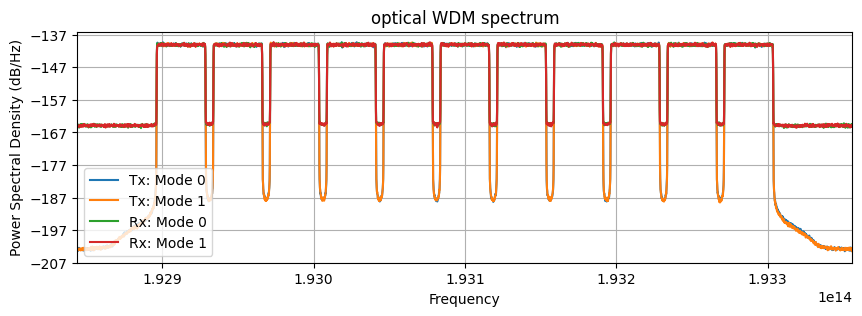

In [22]:
# plot psd
Fs = paramCh.Fs
fig,_ = plotPSD(sigWDM_Tx, Fs, paramCh.Fc, label='Tx'); 
fig, ax = plotPSD(sigWDM, Fs, paramCh.Fc, fig=fig, label='Rx');
fig.set_figheight(3)
fig.set_figwidth(10)
ax.set_title('optical WDM spectrum');

## Coherent detection, digital signal processing and data demodulation

### Optical coherent receiver

Demodulating channel #5 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 100.00 kHz, FO: 150.00 MHz



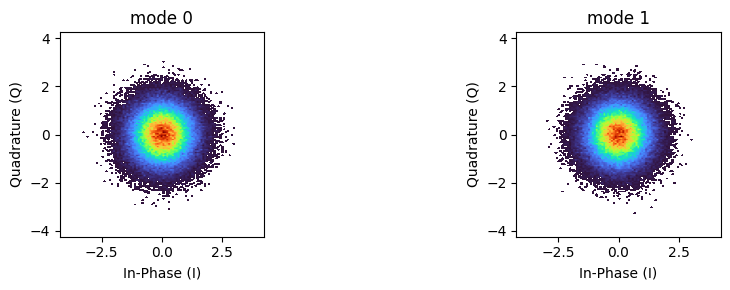

In [23]:
# Receiver

# parameters
chIndex  = int(np.floor(paramTx.nChannels/2))      # index of the channel to be demodulated

Fc = paramCh.Fc
Ts = 1/Fs
freqGrid = paramTx.wdmFreqGrid
π  = np.pi
t  = np.arange(0, len(sigWDM))*Ts

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 150e6                 # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated

# generate CW laser LO field
paramLO = parameters()
paramLO.P = 10              # power in dBm
paramLO.lw = 100e3          # laser linewidth
paramLO.RIN_var = 0
paramLO.Ns = len(sigWDM)
paramLO.Fs = Fs

sigLO = basicLaserModel(paramLO)
sigLO = sigLO*np.exp(1j*2*π*Δf_lo*t) # add frequency offset

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(paramLO.P, paramLO.lw/1e3, FO/1e6))

# polarization multiplexed coherent optical receiver

# photodiodes parameters
paramPD = parameters()
paramPD.B = paramTx.Rs
paramPD.Fs = Fs    
paramPD.ideal = True

θsig = π/3 # polarization rotation angle
sigRx = pdmCoherentReceiver(sigWDM, sigLO, θsig, paramPD)

# plot received constellations
pconst(sigRx[0::paramTx.SpS,:], R=3);

### Matched filtering

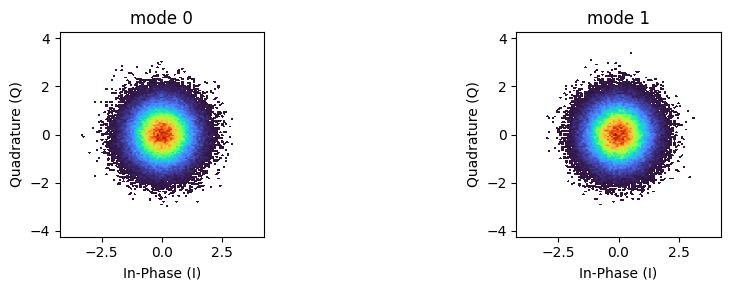

(<Figure size 1000x300 with 2 Axes>,
 <ScatterDensityAxes: title={'center': 'mode 1'}, xlabel='In-Phase (I)', ylabel='Quadrature (Q)'>)

In [24]:
# Rx filtering

# Matched filtering
paramPS = parameters()
paramPS.SpS = paramTx.SpS
paramPS.nFilterTaps = paramTx.nFilterTaps
paramPS.rollOff = paramTx.pulseRollOff
paramPS.pulseType = paramTx.pulseType

pulse = pulseShape(paramPS)    
pulse = pulse/np.sum(pulse)

sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramTx.SpS,:], R=3)

### Downsampling to 2 samples/symbol and CD compensation 

In [25]:
# decimation
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 2
sigRx = decimate(sigRx, paramDec)

Running CD compensation...
CD filter length: 392 taps, FFT size: 512


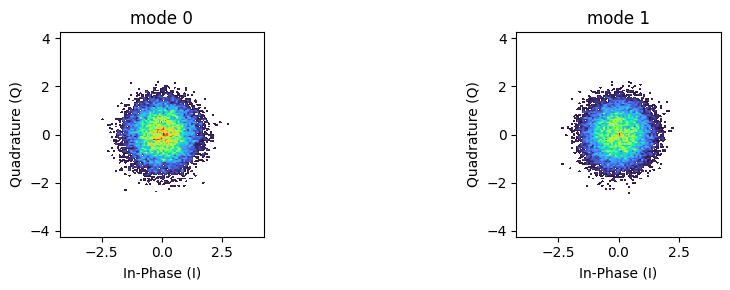

In [26]:
# CD compensation
paramEDC = parameters()
paramEDC.L = paramCh.Ltotal
paramEDC.D = paramCh.D
paramEDC.Fc = Fc-Δf_lo
paramEDC.Rs = paramTx.Rs
paramEDC.Fs = 2*paramTx.Rs

sigRx = edc(sigRx, paramEDC)

# plot constellations after CD compensation
pconst(sigRx[0::paramTx.SpS,:], R=3);

# re-synchronization with transmitted sequences
symbRx = symbolSync(sigRx, symbTx, 2)

### Power normalization

In [27]:
x = pnorm(sigRx)
d = pnorm(symbRx)

### Adaptive equalization

Running adaptive equalizer...
da-rde - training stage #0
da-rde pre-convergence training iteration #0
da-rde MSE = 0.021754.
da-rde pre-convergence training iteration #1
da-rde MSE = 0.016505.
da-rde pre-convergence training iteration #2
da-rde MSE = 0.016468.
da-rde pre-convergence training iteration #3
da-rde MSE = 0.016446.
da-rde pre-convergence training iteration #4
da-rde MSE = 0.016429.
rde - training stage #1
rde MSE = 0.012959.


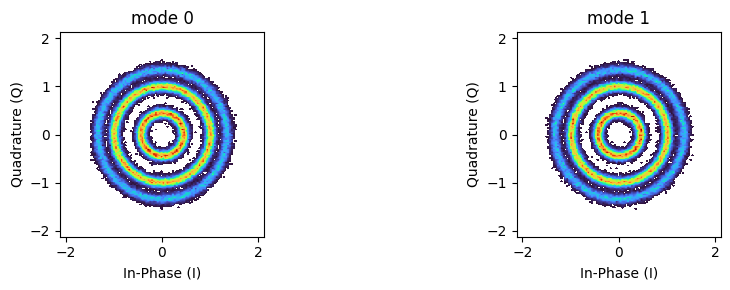

In [28]:
# adaptive equalization parameters
paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = paramDec.SpS_out
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.M = paramTx.M
paramEq.shapingFactor = paramTx.shapingFactor
paramEq.L = [int(0.2*d.shape[0]), int(0.8*d.shape[0])]
paramEq.prgsBar = False

if paramTx.M == 4:
    paramEq.alg = ['cma','cma'] # QPSK
    paramEq.mu = [5e-3, 1e-3] 
else:
    paramEq.alg = ['da-rde','rde'] # M-QAM
    paramEq.mu = [5e-3, 2e-4] 
    
y_EQ = mimoAdaptEqualizer(x, paramEq, d)

#plot constellations after adaptive equalization
discard = 5000
pconst(y_EQ[discard:-discard,:], R=1.5);

### Carrier frequency offset and phase recovery

Running frequency offset compensation...
Running BPS carrier phase recovery...


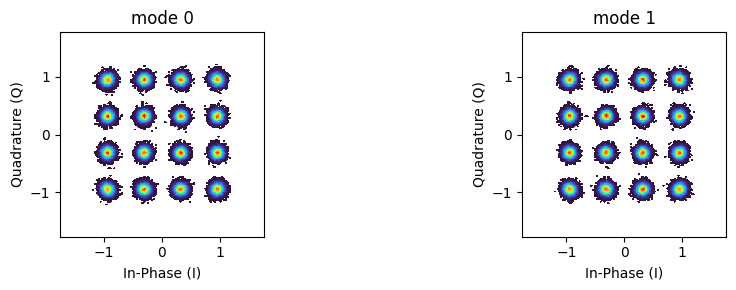

In [29]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.constType = paramTx.constType
paramCPR.shapingFactor = paramTx.shapingFactor
paramCPR.N   = 75
paramCPR.B   = 64

y_CPR = cpr(y_EQ, paramCPR)

discard = 5000

#plot constellations after CPR
pconst(y_CPR[discard:-discard,:]);

### Evaluate transmission metrics

In [30]:
ind = np.arange(discard, d.shape[0]-discard)

# remove phase and polarization ambiguities for QPSK signals
if paramTx.M == 4:   
    d = symbTx
    # find rotations after CPR and/or polarizations swaps possibly added at the output the adaptive equalizer:
    rot0 = [np.mean(pnorm(symbTx[ind,0])/pnorm(y_CPR[ind,0])), np.mean(pnorm(symbTx[ind,1])/pnorm(y_CPR[ind,0]))]
    rot1 = [np.mean(pnorm(symbTx[ind,1])/pnorm(y_CPR[ind,1])), np.mean(pnorm(symbTx[ind,0])/pnorm(y_CPR[ind,1]))]

    if np.argmax(np.abs(rot0)) == 1 and np.argmax(np.abs(rot1)) == 1:      
        y_CPR_ = y_CPR.copy() 
        # undo swap and rotation 
        y_CPR[:,0] = pnorm(rot1[np.argmax(np.abs(rot1))]*y_CPR_[:,1]) 
        y_CPR[:,1] = pnorm(rot0[np.argmax(np.abs(rot0))]*y_CPR_[:,0])
    else:
        # undo rotation
        y_CPR[:,0] = pnorm(rot0[np.argmax(np.abs(rot0))]*y_CPR[:,0])
        y_CPR[:,1] = pnorm(rot1[np.argmax(np.abs(rot1))]*y_CPR[:,1])
        

BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam',px=paramTx.pmf)
GMI, NGMI = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam',px=paramTx.pmf)
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam',px=paramTx.pmf)
EVM      = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))
print(' EVM: %.2f %%,    %.2f %%'%(EVM[0]*100, EVM[1]*100))
print('  MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print(' GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))
print('NGMI: %.2f,      %.2f'%(NGMI[0], NGMI[1]))

      pol.X      pol.Y      
 SER: 0.00e+00,  0.00e+00
 BER: 0.00e+00,  0.00e+00
 SNR: 21.47 dB,  21.51 dB
 EVM: 0.72 %,    0.71 %
  MI: 4.00 bits, 4.00 bits
 GMI: 4.00 bits, 4.00 bits
NGMI: 1.00,      1.00


### References

[1] D. Marcuse, C. R. Menyuk, e P. K. A. Wai, “Application of the Manakov-PMD equation to studies of signal propagation in optical fibers with randomly varying birefringence”, Journal of Lightwave Technology, vol. 15, nº 9, p. 1735–1745, 1997, doi: 10.1109/50.622902.

[2] S. J. Savory, “Digital coherent optical receivers: Algorithms and subsystems”, IEEE Journal on Selected Topics in Quantum Electronics, vol. 16, nº 5, p. 1164–1179, set. 2010, doi: 10.1109/JSTQE.2010.2044751.

[3] K. Kikuchi, “Fundamentals of Coherent Optical Fiber Communications”, J. Lightwave Technol., JLT, vol. 34, nº 1, p. 157–179, jan. 2016.